In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
from sklearn.model_selection import train_test_split


from PIL import Image
import cv2

from keras.layers import Dense, Dropout, Flatten, Input, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.utils import plot_model
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from numpy import array 
from keras import regularizers
from keras import optimizers

4  CPU cores


Using TensorFlow backend.
C:\Users\Zakaria\.conda\envs\Tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Zakaria\.conda\envs\Tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Zakaria\.conda\envs\Tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Zakaria\.conda\envs\Tensor\lib\site-pa

In [3]:
def load_data():
    file = open('df_train_train', 'rb')
    df_train_train = pickle.load(file)
    file.close()

    file = open('df_train_test', 'rb')
    df_train_test = pickle.load(file)
    file.close()
    
    return df_train_train,df_train_test

In [4]:
df_train_train,df_train_test = load_data()
print(df_train_train.shape,df_train_test.shape,'\n')
df_train_train.head(6)

(2929, 4) (733, 4) 



,id_code,diagnosis,file_path,file_name
418,1df0431bfa73,0,./train_images/1df0431bfa73.png,1df0431bfa73.png
922,42b08dca9b2f,2,./train_images/42b08dca9b2f.png,42b08dca9b2f.png
3535,f61bf44c677c,2,./train_images/f61bf44c677c.png,f61bf44c677c.png
2043,8fbb2ca39911,0,./train_images/8fbb2ca39911.png,8fbb2ca39911.png
1817,807135cbc438,2,./train_images/807135cbc438.png,807135cbc438.png
2230,9c893e16c055,0,./train_images/9c893e16c055.png,9c893e16c055.png


In [14]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 50
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [5]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory = "./test_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      class_mode="categorical",
                                                      shuffle=False)
    
    return train_generator,test_generator

In [6]:
train_generator,test_generator = img_generator(df_train_train,df_train_test)

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


In [7]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_TEST)

366 733


In [8]:
import tensorflow as tf
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks.callbacks import EarlyStopping,ReduceLROnPlateau

In [9]:
visible = Input(shape=(320,320,3))
conv1 = Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1, 1))(visible)
conv2 = Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1, 1))(conv1)
conv3 = ZeroPadding2D(padding=(1, 1))(conv2)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
#bat1 = BatchNormalization(axis = 1)(pool1)

conv4 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01))(pool1)
conv5 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01))(conv4)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv5)

conv6 = Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1, 1), padding='valid')(pool2)
conv7 = Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1, 1), padding='valid')(conv6)
conv7 = ZeroPadding2D(padding=(1, 1))(conv7)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv7)

conv8 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01))(pool3)
conv9 = Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid')(conv8)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv9)

flat = Flatten()(pool4)
hidden1 = Dense(64, activation='relu')(flat)
drop1 = Dropout(0.3)(hidden1)

hidden2 = Dense(32, activation='relu')(drop1)
drop2 = Dropout(0.2)(hidden2)

output = Dense(5, activation='softmax')(drop2)
#output = Dense(1, activation='sigmoid')(flat)
model = Model(inputs=visible, outputs=output)

In [15]:
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=['accuracy'])

In [16]:
m1 = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=test_generator,
                                          validation_steps=STEP_SIZE_TEST,
                                          epochs=EPOCHS,
                                          verbose=1).history

Epoch 1/50
366/366 [==============================] - 592s 2s/step - loss: 1.2635 - accuracy: 0.6012 - val_loss: 3.8585 - val_accuracy: 0.5648
Epoch 2/50
366/366 [==============================] - 572s 2s/step - loss: 1.1888 - accuracy: 0.6296 - val_loss: 2.7026 - val_accuracy: 0.6658
Epoch 3/50
366/366 [==============================] - 572s 2s/step - loss: 1.1442 - accuracy: 0.6398 - val_loss: 3.0519 - val_accuracy: 0.6958
Epoch 4/50
366/366 [==============================] - 574s 2s/step - loss: 1.1077 - accuracy: 0.6546 - val_loss: 2.9670 - val_accuracy: 0.6944
Epoch 5/50
366/366 [==============================] - 571s 2s/step - loss: 1.0753 - accuracy: 0.6600 - val_loss: 2.1551 - val_accuracy: 0.6617
Epoch 6/50
366/366 [==============================] - 570s 2s/step - loss: 1.0675 - accuracy: 0.6700 - val_loss: 2.6659 - val_accuracy: 0.7080
Epoch 7/50
366/366 [==============================] - 570s 2s/step - loss: 1.0480 - accuracy: 0.6758 - val_loss: 2.0377 - val_accuracy: 0.7094

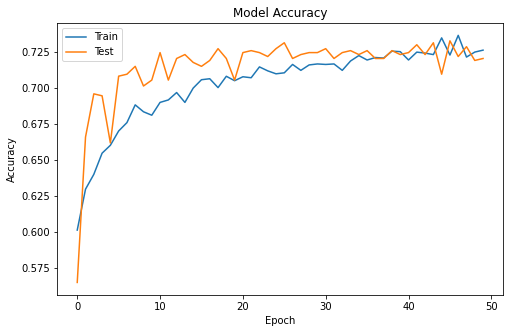

In [19]:
plt.figure(figsize=(8,5))

plt.plot(m1['accuracy'])
plt.plot(m1['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

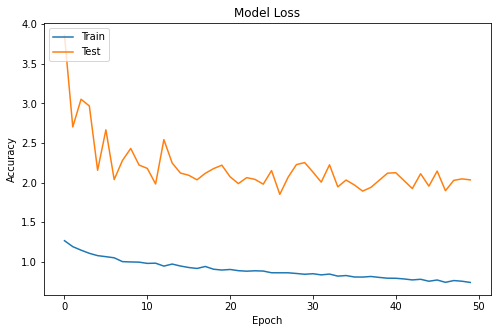

In [20]:
plt.figure(figsize=(8,5))

plt.plot(m1['loss'])
plt.plot(m1['val_loss'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [21]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory = "./train_images_resized_preprocessed/",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 2929 validated image filenames.
2929/2929 [==============================] - 171s 58ms/step


In [22]:
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['diagnosis'].astype('int'),train_preds))

Train Accuracy score : 0.736


In [1]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

NameError: name 'test_generator' is not defined

In [24]:
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))

Test Accuracy score : 0.720
